In [2]:
# importando algumas bibliotecas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr, kendalltau, norm

In [3]:
# carregando os dados baseados em Kline (2016), capítulo 2
kline = pd.read_csv("Kline (2016), Chapter 2.csv", index_col = "Caso")
kline.head(5)

,X,W,Y
Caso,,,
A,16,48,100
B,14,47,92
C,16,45,88
D,12,45,95
E,18,46,98


Primeiro, vamos criar nossa própria função `pearson` que calculará a correlação de Pearson.

In [9]:
# criando uma função que calcula a correlação de Pearson entre duas variáveis na unha
def pearson(x, y):
    '''
    Calcula a correlação de Pearson entre duas variáveis e retorna o valor do coeficiente, r.
    '''
    
    # vetores precisam ter o mesmo comprimento!
    if x.size != y.size:
        raise Exception("Erro! Os dois vetores precisam ter o mesmo comprimento")

    # no numerador, calculamos os produtos dos desvios cruzados das duas variáveis
    numerador = np.sum((x - x.mean()) * (y - y.mean()))

    # no denominador, calculamos o produto dos graus de liberdade (número de pares - 1)
    # e os desvios-padrões das duas variáveis
    denominador = x.size * np.std(x) * np.std(y)

    # calcula o r
    r = numerador / denominador
    return r

# testando se a função funciona
meu_rxy = pearson(kline["X"], kline["Y"])
meu_rxw = pearson(kline["X"], kline["W"])
meu_ryw = pearson(kline["Y"], kline["W"])

print(f"Correlações: X e Y = {meu_rxy:.3f}; X e Z = {meu_rxw:.3f}; Y e W = {meu_ryw:.3f}.")

Correlações: X e Y = 0.686; X e Z = 0.272; Y e W = 0.499.


Obviamente, não precisamos criar uma função. A função acima foi criada apenas para exercitar a programação. Na prática, o próprio Python possui bibliotecas com a função já implementada. Para checar se nossa função retornou o valor correto. Vamos agora usar o `Numpy` para calcular a correlação de Pearson.

In [10]:
# correlações de Pearson usando o NumPy
rxy = np.corrcoef(kline["X"], kline["Y"])[0][1]
rxw = np.corrcoef(kline["X"], kline["W"])[0][1]
ryw = np.corrcoef(kline["Y"], kline["W"])[0][1]

print(f"Correlações: X e Y = {rxy:.3f}; X e Z = {rxw:.3f}; Y e W = {ryw:.3f}.")

Correlações: X e Y = 0.686; X e Z = 0.272; Y e W = 0.499.


Os valores bateram! :)
Agora, vamos gerar uma matriz de correlação de Pearson usando o `Pandas`.

In [11]:
# Matriz de correlações de Pearson usando Pandas
kline.corr(method = "pearson").round(decimals = 3)

,X,W,Y
X,1.000,0.272,0.686
W,0.272,1.000,0.499
Y,0.686,0.499,1.000


Mais uma vez, os resultados bateram. Agora, vamos calcular a correlação de Spearman. Desta vez, usaremos direto o `Pandas`.

In [12]:
# Matriz de correlações de Spearman usando Pandas
kline.corr(method = "spearman").round(decimals = 3)

,X,W,Y
X,1.000,0.252,0.734
W,0.252,1.000,0.554
Y,0.734,0.554,1.000


E agora, a correlação de Kendall. Mais uma vez, com o `Pandas`.

In [13]:
kline.corr(method = "kendall").round(decimals = 3)

,X,W,Y
X,1.00,0.200,0.570
W,0.20,1.000,0.437
Y,0.57,0.437,1.000


*Marcos, mas os valores acima não retornam o valor* p. *Como eu faço?*
Para obter o valor *p*, precisaremos usar a função `pearsonr`, do `scipy.stats`.

In [14]:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html
rxy, pxy = pearsonr(kline["X"], kline["Y"])
rxw, pxw = pearsonr(kline["X"], kline["W"])
ryw, pyw = pearsonr(kline["Y"], kline["W"])

# imprime rs e ps
print(f"r(X, Y) = {rxy:.3f}, p = {pxy:.3f}")
print(f"r(X, W) = {rxw:.3f}, p = {pxw:.3f}")
print(f"r(Y, W) = {ryw:.3f}, p = {pyw:.3f}")

r(X, Y) = 0.686, p = 0.001
r(X, W) = 0.272, p = 0.246
r(Y, W) = 0.499, p = 0.025


Se você quiser ser ainda mais moderninho e reportar intervalos de confiança, ao invés do valor *p*, também é possivel. Veja:

In [15]:
# criando uma função, parcialmente inspirada em:
# https://zhiyzuo.github.io/Pearson-Correlation-CI-in-Python/

def pearson_cis(x, y, ICs: int = 95):
    '''
    Calcula r de Perason e seus ICs i%; default é 95%.
    '''
    
    if not (1 <= ICs <= 99):
        raise Exception("A confiança do IC deve ser um valor entre 1 e 99!")
    
    # função chama pearsonr
    r, p = pearsonr(x, y)
    
    # intervalos de confiança são calculados após transformação r para z de Fisher
    r_z = np.arctanh(r)

    # erro padrão (se) do r
    ep = 1 / np.sqrt(x.size - 3)

    # alfa; se queremos IC 95%, então alfa = 0,05
    alfa = 1 - (ICs / 100)

    # z crítico da distribuição normal padrão para cálculo dos ICs
    z = norm.ppf(1 - alfa / 2)
    
    # limites inferior (li) e superior (ls) do z transformado de Fisher
    r_z_li, r_z_ls = r_z - z * ep, r_z + z * ep
    
    # transformação z para r de Fisher; retorna os ICs do r para a métrica original do r
    ic_li, ic_ls = np.tanh((r_z_li, r_z_ls))
    
    return r, p, ic_li, ic_ls

# testando a função; _ indica que o valor p não será usado
r, _, li, ls = pearson_cis(kline["X"], kline["Y"])

# e imprimindo o resultado
print(f"r = {r:.3f}, IC 95% [{li:.3f}, {ls:.3f}].")

r = 0.686, IC 95% [0.349, 0.866].


$\rho$ de Spearman com valor *p*

In [16]:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.spearmanr.html
rhoxy, pxy = spearmanr(kline["X"], kline["Y"])
rhoxw, pxw = spearmanr(kline["X"], kline["W"])
rhoyw, pyw = spearmanr(kline["Y"], kline["W"])

# imprime rs e ps
print(f"r(X, Y) = {rhoxy:.3f}, p = {pxy:.4f}")
print(f"r(X, W) = {rhoxw:.3f}, p = {pxw:.3f}")
print(f"r(Y, W) = {rhoyw:.3f}, p = {pyw:.3f}")


r(X, Y) = 0.734, p = 0.0002
r(X, W) = 0.252, p = 0.283
r(Y, W) = 0.554, p = 0.011


$\tau$ de Kendall com valor *p*

In [17]:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kendalltau.html
tauxy, pxy = kendalltau(kline["X"], kline["Y"])
tauxw, pxw = kendalltau(kline["X"], kline["W"])
tauyw, pyw = kendalltau(kline["Y"], kline["W"])

# imprime rs e ps
print(f"r(X, Y) = {tauxy:.3f}, p = {pxy:.4f}")
print(f"r(X, W) = {tauxw:.3f}, p = {pxw:.3f}")
print(f"r(Y, W) = {tauyw:.3f}, p = {pyw:.3f}")

r(X, Y) = 0.570, p = 0.0008
r(X, W) = 0.200, p = 0.246
r(Y, W) = 0.437, p = 0.009


Correlação parcial entre X e Y, removendo os efeitos de W, calculada na unha:

In [18]:
def partial_r(x, y, z):
    '''
    Calcula a correlação entre x e y, após remover os efeitos de z.
    Função se aplica a apenas uma variável parcial. Retorna o r parcial.
    '''
    
    # calculando rs de Pearson
    rxy, _ = pearsonr(x, y)
    rxz, _ = pearsonr(x, z)
    ryz, _ = pearsonr(y, z)
    
    # calculando r parcial
    partial_rxy = (rxy - (rxz * ryz)) / (((1 - rxz ** 2) * (1 - ryz ** 2)) ** 0.5)
    
    return partial_rxy

# testando a função
r = partial_r(kline["X"], kline["Y"], kline["W"])
print(f"r parcial = {r:.3f}.")    

r parcial = 0.660.


e, para finalizar, que tal alguns gráficos com o `matplotlib`?

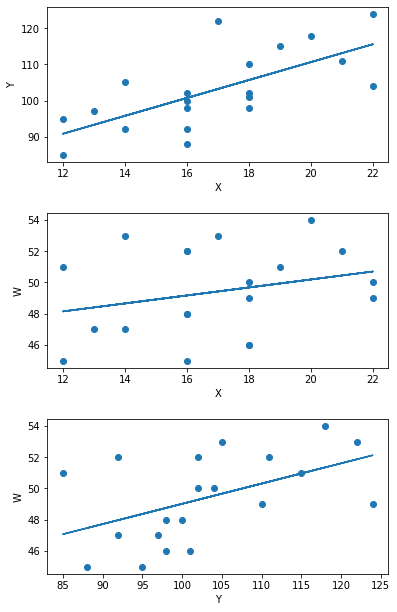

In [33]:
# linhas de melhores ajustes
slope_xy, intercept_xy = np.polyfit(kline["X"], kline["Y"], 1)
slope_xw, intercept_xw = np.polyfit(kline["X"], kline["W"], 1)
slope_yw, intercept_yw = np.polyfit(kline["Y"], kline["W"], 1)

# gráficos
fig, ax = plt.subplots(figsize = (6, 9), nrows = 3, ncols = 1, sharex = False, sharey = False)

fig.tight_layout(pad = 3.0)

ax[0].scatter(kline["X"], kline["Y"])
ax[0].set_xlabel("X")
ax[0].set_ylabel("Y")
ax[0].plot(kline["X"], slope_xy * kline["X"] + intercept_xy)

ax[1].scatter(kline["X"], kline["W"])
ax[1].set_xlabel("X")
ax[1].set_ylabel("W")
ax[1].plot(kline["X"], slope_xw * kline["X"] + intercept_xw)

ax[2].scatter(kline["Y"], kline["W"])
ax[2].set_xlabel("Y")
ax[2].set_ylabel("W")
ax[2].plot(kline["Y"], slope_yw * kline["Y"] + intercept_yw)

plt.savefig('005 - Correlações.jpg', dpi = 600, bbox_inches = "tight")

plt.show()